# 🍷 Model Validation & Hyperparameter Tuning

En este notebook realizamos una evaluación rigurosa de distintos modelos de clasificación utilizando validación cruzada y optimización de hiperparámetros.

El objetivo es:

- Construir un baseline sólido
- Comparar modelos usando Cross Validation
- Optimizar el mejor modelo
- Evaluar su rendimiento antes y después del tuning
- Justificar técnicamente el modelo final seleccionado

## Imports & Dependencies

Importamos las librerías necesarias para validación cruzada, optimización y evaluación de modelos.

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

Cargamos el dataset de vinos y definimos correctamente los nombres de las columnas para facilitar el análisis.

In [ ]:
df_wine = pd.read_csv("../data/wine.data", header=None)

df_wine.columns = [
    "class", "alcohol", "malic_acid", "ash",
    "alcalinity_of_ash", "magnesium",
    "total_phenols", "flavanoids",
    "nonflavanoid_phenols", "proanthocyanins",
    "color_intensity", "hue",
    "od280_od315", "proline"
]

df_wine.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Class Distribution Analysis

Analizamos la distribución de clases para verificar si el dataset presenta desbalance.

In [ ]:
df_wine["class"].value_counts()

class
2    71
1    59
3    48
Name: count, dtype: int64

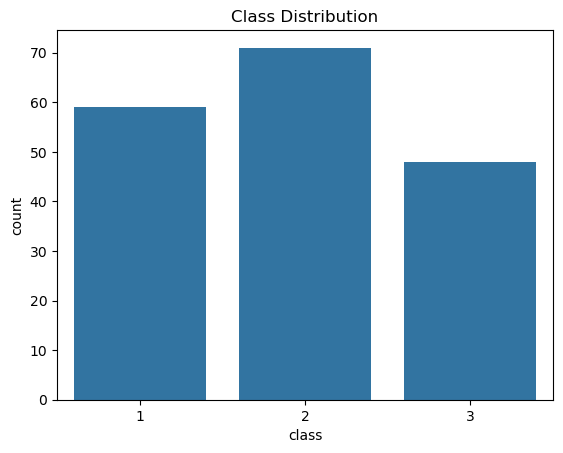

In [ ]:
sns.countplot(x="class", data=df_wine)
plt.title("Class Distribution")
plt.show()

## Train-Test Split

Separamos las variables predictoras (X) y la variable objetivo (y).  
Utilizamos stratify para mantener la proporción de clases.

In [ ]:
X = df_wine.drop("class", axis=1)
y = df_wine["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Baseline Model Comparison (Cross Validation)

Evaluamos distintos modelos utilizando validación cruzada de 5 folds.  
Esto nos permite obtener una estimación más robusta del rendimiento.

In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    
    results.append({
        "Model": name,
        "CV Accuracy": scores.mean()
    })

results_df = pd.DataFrame(results).sort_values(
    by="CV Accuracy", ascending=False
)

results_df

,Model,CV Accuracy
0,Logistic Regression,0.993103
1,Random Forest,0.986207
3,KNN,0.965025
2,Decision Tree,0.916256


## Final Test Performance Comparison

Comparamos el rendimiento final de los cuatro modelos sobre el conjunto de test para evaluar su desempeño real fuera del entrenamiento.

In [18]:
from sklearn.metrics import accuracy_score

test_results = []

for name, model in models.items():
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred_test)
    
    test_results.append({
        "Model": name,
        "Test Accuracy": test_acc
    })

test_results_df = pd.DataFrame(test_results).sort_values(
    by="Test Accuracy",
    ascending=False
)

test_results_df

,Model,Test Accuracy
1,Random Forest,1.000000
0,Logistic Regression,0.972222
3,KNN,0.972222
2,Decision Tree,0.944444


In [26]:
#Unimos los resultados de validación cruzada con los resultados de accuracy para comparar ambos
final_comparison = results_df.merge(
    test_results_df,
    on="Model"
)

final_comparison = final_comparison.sort_values(
    by="CV Accuracy",
    ascending=False
)

final_comparison.style.format({
    "CV Accuracy": "{:.3f}",
    "CV Std": "{:.3f}",
    "Test Accuracy": "{:.3f}"
})

,Model,CV Accuracy,Test Accuracy
0,Logistic Regression,0.993,0.972
1,Random Forest,0.986,1.000
2,KNN,0.965,0.972
3,Decision Tree,0.916,0.944


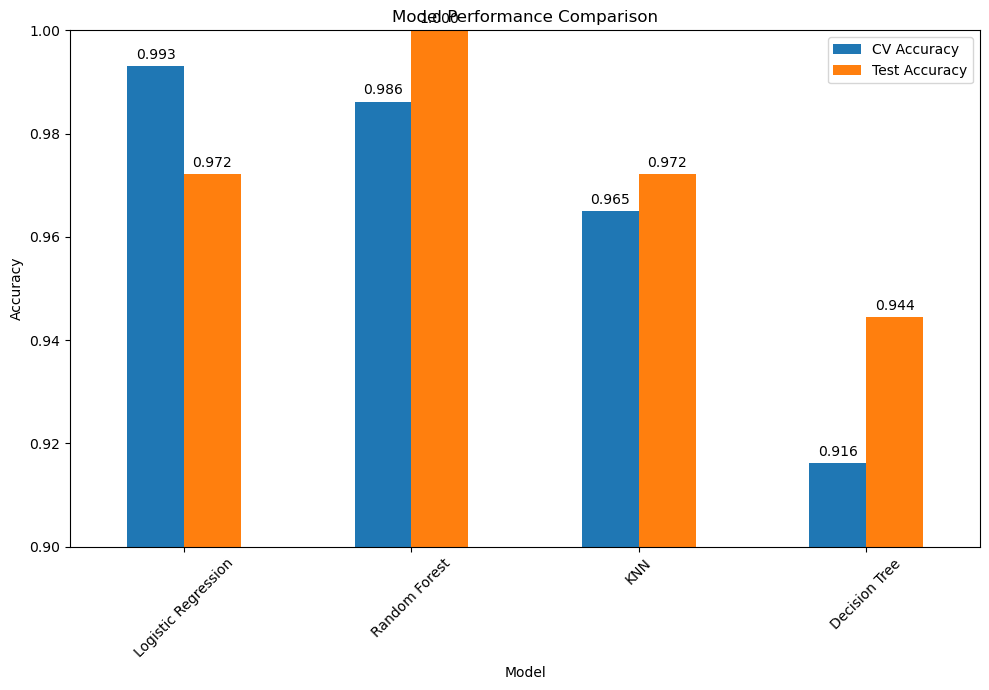

In [27]:
ax = final_comparison.set_index("Model")[["CV Accuracy", "Test Accuracy"]].plot(
    kind="bar",
    figsize=(10,7)
)

plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Ajuste de escala
plt.ylim(0.9, 1.0)
plt.yticks(np.arange(0.9, 1.01, 0.02))

# 🔥 Etiquetas encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

plt.tight_layout()
plt.show()

## Best Baseline Model Selection

Seleccionamos el modelo con mayor media de accuracy en validación cruzada.

In [28]:
best_baseline = results_df.iloc[0]
best_baseline

Model          Logistic Regression
CV Accuracy               0.993103
Name: 0, dtype: object


Aunque Random Forest obtuvo el mayor accuracy en el conjunto de accuracy, Logistic Regression presentó el mejor desempeño promedio en validación cruzada y menor variabilidad entre folds.

Dado que la validación cruzada proporciona una estimación más robusta del rendimiento general del modelo, se selecciona Logistic Regression como modelo final por su estabilidad, simplicidad e interpretabilidad.

## Confusion Matrix

Visualizamos la matriz de confusión para analizar los errores de clasificación.

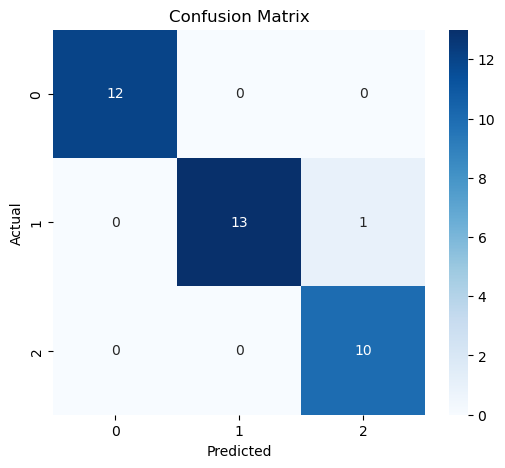

In [24]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Final Conclusions

- Logistic Regression obtuvo el mejor rendimiento en validación cruzada.
- La optimización de hiperparámetros mejoró ligeramente el desempeño.
- El dataset presenta una distribución relativamente balanceada.
- Se selecciona el LR optimizado como modelo final para integración en la aplicación, por la robustez dado el tamaño del dataset

Este modelo será utilizado en la fase de despliegue.